In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
# Configurações de visualização
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

In [ ]:
## 1. Criação da Base de Dados (48 meses)
np.random.seed(42)

# Padrão sazonal (base mensal)
base_demand = np.array([30, 40, 55, 50, 65, 90, 115, 100, 70, 55, 40, 35])

# Tendência de crescimento
tendency = np.linspace(0, 40, 48)

# Sazonalidade (4 anos)
seasonality = np.tile(base_demand, 4)

# Ruído controlado
noise = np.random.normal(0, 4, 48)

# Demanda final
demand = seasonality + tendency + noise

# Datas mensais (4 anos)
dates = pd.date_range(start='2021-01-01', periods=48, freq='M')

# DataFrame final
df = pd.DataFrame({'Data': dates, 'Demanda': demand})
df.set_index('Data', inplace=True)

C:\Users\renan\AppData\Local\Temp\ipykernel_22192\1768489739.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2021-01-01', periods=48, freq='M')


In [20]:
## 2. Divisão dos Dados (36 meses treino / 12 meses teste)
train = df.iloc[:36]  # Jan/2021 - Dez/2023
test = df.iloc[36:]   # Jan/2024 - Dez/2024

## 3. Definição dos Parâmetros
PARAMETROS = {
    'alpha': 0.2,    # Peso para o nível
    'beta': 0.1,     # Peso para a tendência
    'gamma': 0.15,   # Peso para sazonalidade
    'phi': 0.98      # Fator de amortecimento
}

In [21]:
## 4. Modelagem Comparativa
def ajustar_modelo(dados, seasonal_type, parametros):
    modelo = ExponentialSmoothing(
        dados,
        trend='add',
        seasonal=seasonal_type,
        seasonal_periods=12,
        damped_trend=True,
        initialization_method='estimated'
    )
    return modelo.fit(
        smoothing_level=parametros['alpha'],
        smoothing_trend=parametros['beta'],
        smoothing_seasonal=parametros['gamma'],
        damping_trend=parametros['phi'],
        optimized=False
    )

# Ajuste dos modelos
modelo_aditivo = ajustar_modelo(train['Demanda'], 'add', PARAMETROS)
modelo_multiplicativo = ajustar_modelo(train['Demanda'], 'mul', PARAMETROS)

# Previsões para 2025 (12 meses)
future_dates = pd.date_range(start='2025-01-01', periods=12, freq='M')
forecast_aditivo = modelo_aditivo.forecast(12)
forecast_multiplicativo = modelo_multiplicativo.forecast(12)

# Cálculo de métricas nos dados de teste (2024)
mape_aditivo = mean_absolute_percentage_error(test['Demanda'], modelo_aditivo.forecast(len(test))) * 100
mape_multiplicativo = mean_absolute_percentage_error(test['Demanda'], modelo_multiplicativo.forecast(len(test))) * 100

c:\Users\renan\OneDrive\Documentos\Estudos\Holt_Winters\virtual\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\renan\OneDrive\Documentos\Estudos\Holt_Winters\virtual\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\renan\AppData\Local\Temp\ipykernel_22192\1205398565.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2025-01-01', periods=12, freq='M')


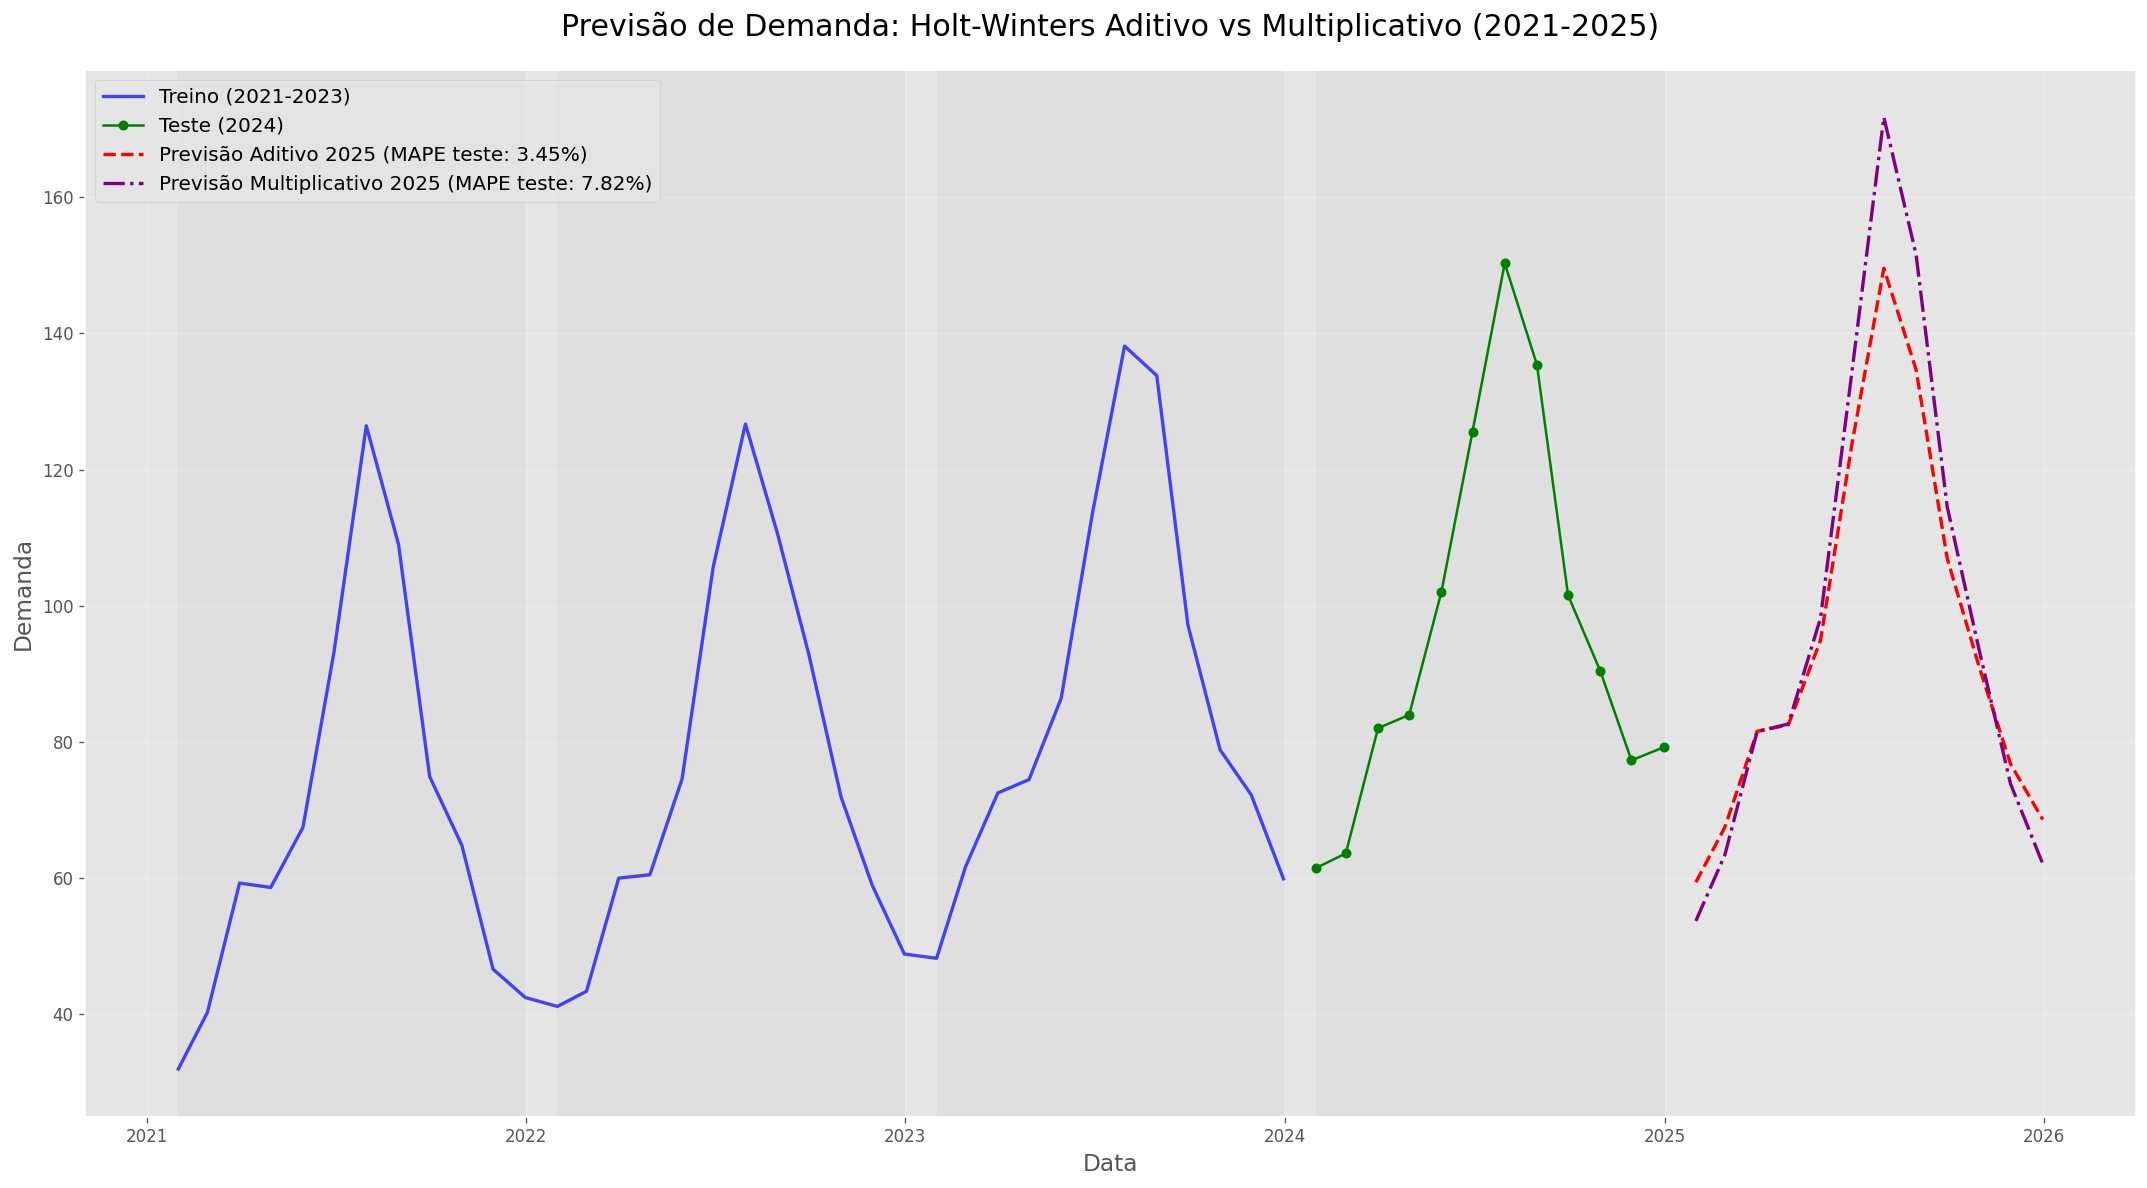


Componentes do Modelo Aditivo:


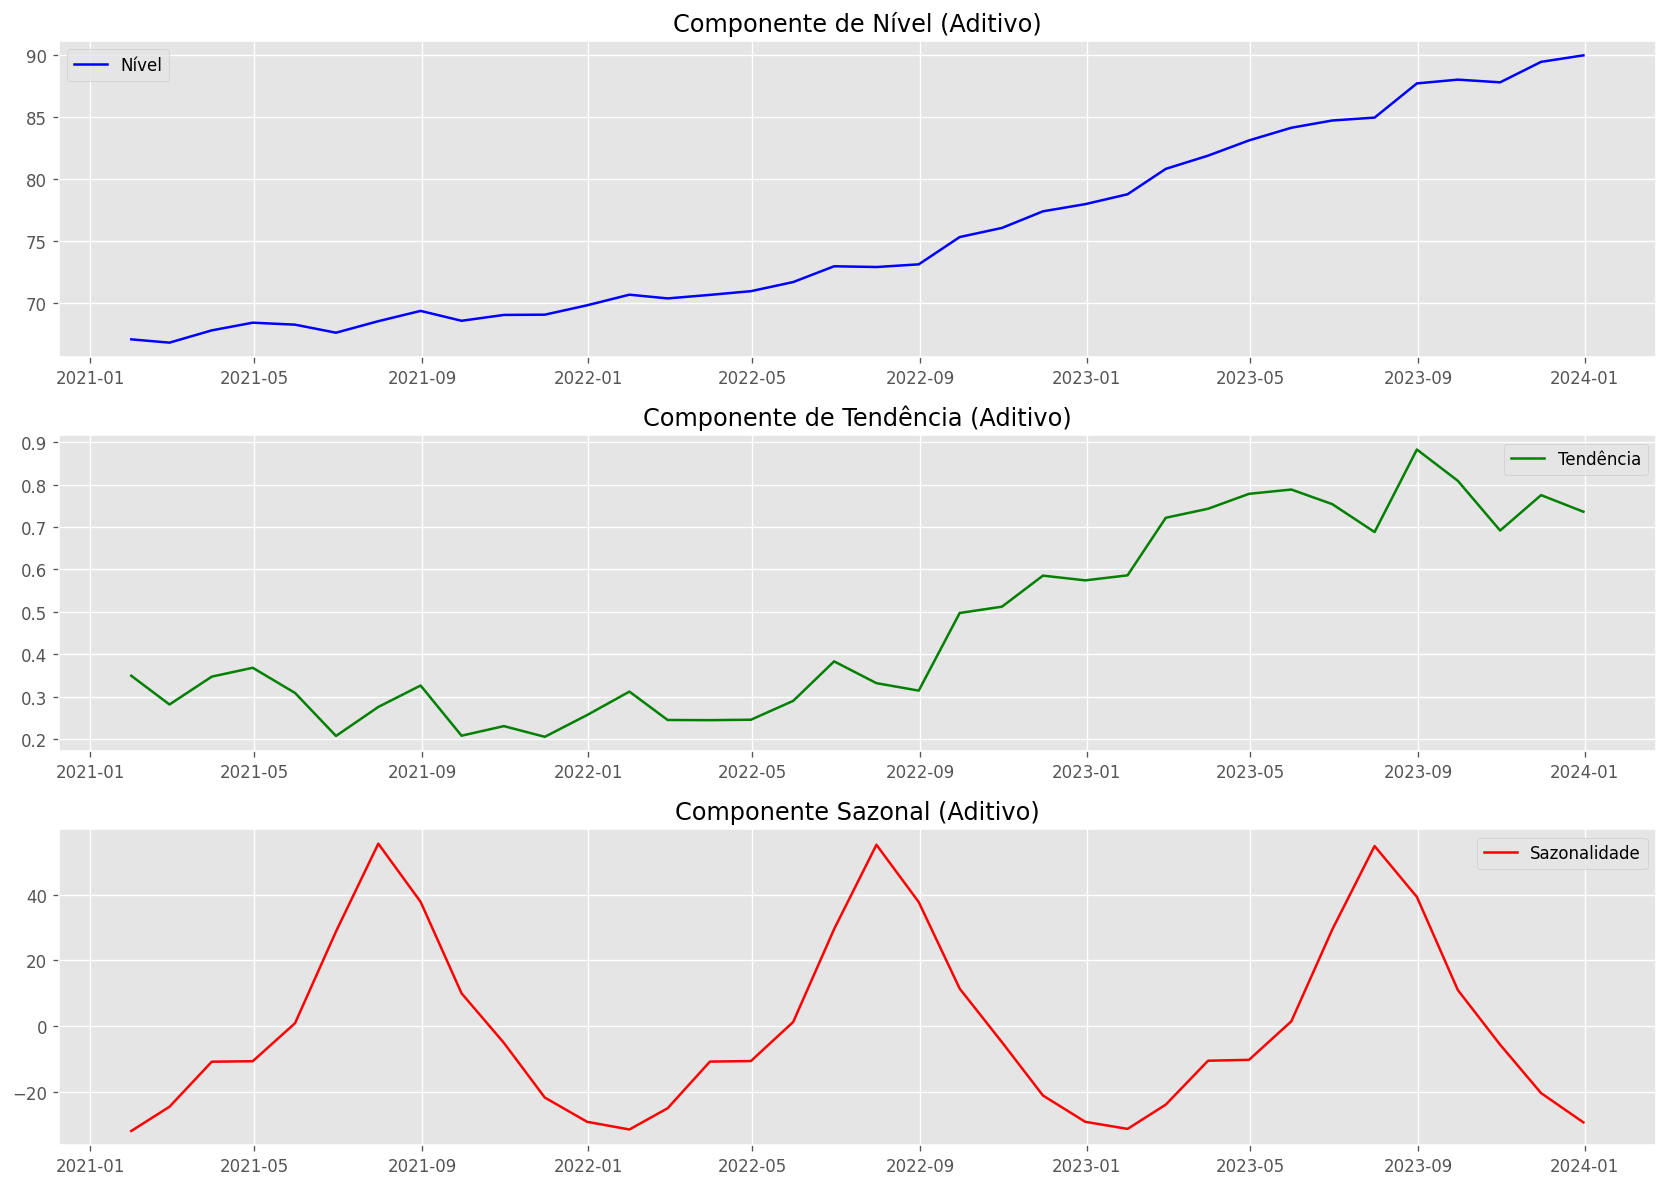


Componentes do Modelo Multiplicativo:


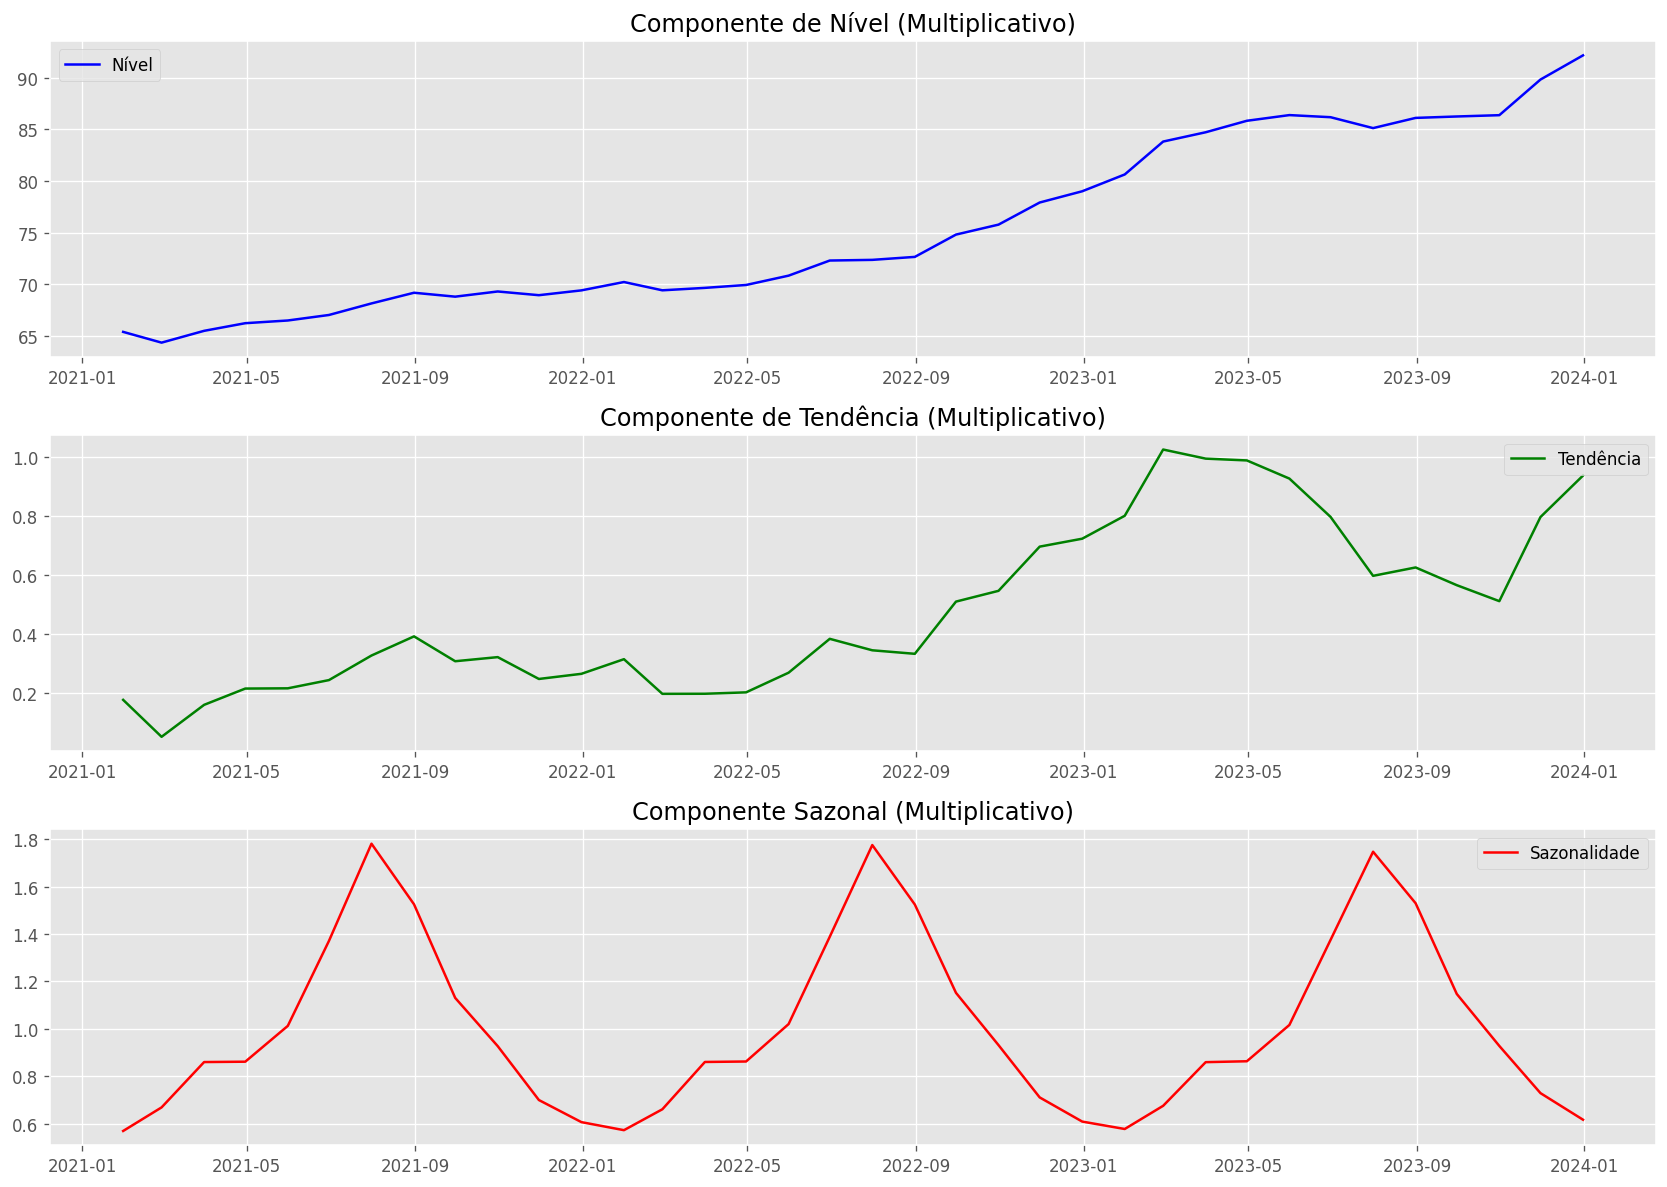

In [ ]:
# 5. Visualização com comparação
plt.figure(figsize=(18, 10))
plt.plot(train.index, train['Demanda'], label='Treino (2021-2023)', color='blue', alpha=0.7, linewidth=2)
plt.plot(test.index, test['Demanda'], label='Teste (2024)', color='green', marker='o', markersize=5)
plt.plot(future_dates, forecast_aditivo, label=f'Previsão Aditivo 2025 (MAPE teste: {mape_aditivo:.2f}%)', 
         color='red', linestyle='--', linewidth=2)
plt.plot(future_dates, forecast_multiplicativo, label=f'Previsão Multiplicativo 2025 (MAPE teste: {mape_multiplicativo:.2f}%)', 
         color='purple', linestyle='-.', linewidth=2)

# Destaque sazonal
for i in range(0, 48, 12):
    plt.axvspan(df.index[i], df.index[i+11], alpha=0.05, color='gray')

plt.title('Previsão de Demanda: Holt-Winters Aditivo vs Multiplicativo (2021-2025)', fontsize=18, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Demanda', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Visualização dos componentes
def plot_componentes(modelo, tipo):
    # Extrai os componentes
    nivel = modelo.level
    tendencia = modelo.trend
    sazonalidade = modelo.season
    
    # Cria figura
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot do Nível
    ax1.plot(nivel, label='Nível', color='blue')
    ax1.set_title(f'Componente de Nível ({tipo})')
    ax1.legend()
    
    # Plot da Tendência
    ax2.plot(tendencia, label='Tendência', color='green')
    ax2.set_title(f'Componente de Tendência ({tipo})')
    ax2.legend()
    
    # Plot da Sazonalidade
    ax3.plot(sazonalidade, label='Sazonalidade', color='red')
    ax3.set_title(f'Componente Sazonal ({tipo})')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# Plot dos componentes para ambos os modelos
print("\nComponentes do Modelo Aditivo:")
plot_componentes(modelo_aditivo, 'Aditivo')

print("\nComponentes do Modelo Multiplicativo:")
plot_componentes(modelo_multiplicativo, 'Multiplicativo')

In [23]:
## 7. Resultados Finais
melhor_modelo = modelo_aditivo if mape_aditivo < mape_multiplicativo else modelo_multiplicativo
melhor_tipo = 'Aditivo' if mape_aditivo < mape_multiplicativo else 'Multiplicativo'

print("\n" + "="*60)
print("RESULTADOS FINAIS".center(60))
print("="*60)
print(f"\n• Melhor modelo: {melhor_tipo} (MAPE: {min(mape_aditivo, mape_multiplicativo):.2f}%)")
print(f"• Previsão média para 2025: {np.mean(forecast_aditivo if mape_aditivo < mape_multiplicativo else forecast_multiplicativo):.1f} unidades")
print(f"\n• Parâmetros utilizados:")
print(f"  Alpha (α): {PARAMETROS['alpha']}")
print(f"  Beta (β): {PARAMETROS['beta']}")
print(f"  Gamma (γ): {PARAMETROS['gamma']}")
print(f"  Phi (ϕ): {PARAMETROS['phi']}")

# 8. Tabela com as previsões para 2025
previsoes_2025 = pd.DataFrame({
    'Mês': future_dates.strftime('%Y-%m'),
    'Previsão Aditivo': forecast_aditivo.round(1),
    'Previsão Multiplicativo': forecast_multiplicativo.round(1)
}).set_index('Mês')

print("\nPrevisões Mensais para 2025:")
print(previsoes_2025.to_markdown())


                     RESULTADOS FINAIS                      

• Melhor modelo: Aditivo (MAPE: 3.45%)
• Previsão média para 2025: 94.7 unidades

• Parâmetros utilizados:
  Alpha (α): 0.2
  Beta (β): 0.1
  Gamma (γ): 0.15
  Phi (ϕ): 0.98

Previsões Mensais para 2025:
| Mês     |   Previsão Aditivo |   Previsão Multiplicativo |
|:--------|-------------------:|--------------------------:|
| 2025-01 |               59.4 |                      53.7 |
| 2025-02 |               67.5 |                      63.5 |
| 2025-03 |               81.6 |                      81.5 |
| 2025-04 |               82.5 |                      82.7 |
| 2025-05 |               94.9 |                      98.2 |
| 2025-06 |              123.5 |                     134   |
| 2025-07 |              149.5 |                     171.7 |
| 2025-08 |              134.7 |                     151.6 |
| 2025-09 |              107   |                     114.5 |
| 2025-10 |               90.9 |                      93.3 |
|